In [1]:
import numpy as np

from scipy.ndimage import gaussian_filter1d, convolve1d
from scipy import convolve

import matplotlib.pyplot as plt

from crispy.utils import calculate_bin_edges

In [2]:
# plt.rcParams["savefig.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
# plt.rcParams["figure.figsize"] = [5, 2]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
# plt.rcParams["text.usetex"] = True

In [3]:
file = "psg_earth_albedo_300-1000nm_R500.txt"
lam, albedo = np.genfromtxt(file, usecols=[0,1]).T

# file1 = "psg_earth_albedo_300-1000nm_R300.txt"
# lam1, albedo1 = np.genfromtxt(file1, usecols=[0,1]).T

In [4]:
def get_earth_reflect_spectrum():
    """
    Get the geometric albedo spectrum of the Earth around the Sun.
    This was produced by Tyler Robinson using the VPL Earth Model
    (Robinson et al., 2011)
    Returns
    -------
    lamhr : numpy.ndarray
    Ahr : numpy.ndarray
    fstar : numpy.ndarray
    """

    fn = 'earth_quadrature_radiance_refl.dat.txt'
    model = np.loadtxt(fn, skiprows=8)
    lamhr = model[:,0]
    radhr = model[:,1]
    fstar = model[:,2]
    reflhr = model[:,3]
    Ahr   = np.pi*(np.pi*radhr/fstar) # hi-resolution reflectivity
    return lamhr, Ahr, fstar

In [5]:
print(lam_hr[1:]/np.diff(lam_hr))

NameError: name 'lam_hr' is not defined

In [8]:
lam_hr, albedo_hr, _ = get_earth_reflect_spectrum()

In [9]:
lam_hr *= 1000

In [10]:
mask = (lam_hr >=300) & (lam_hr <= 1000)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


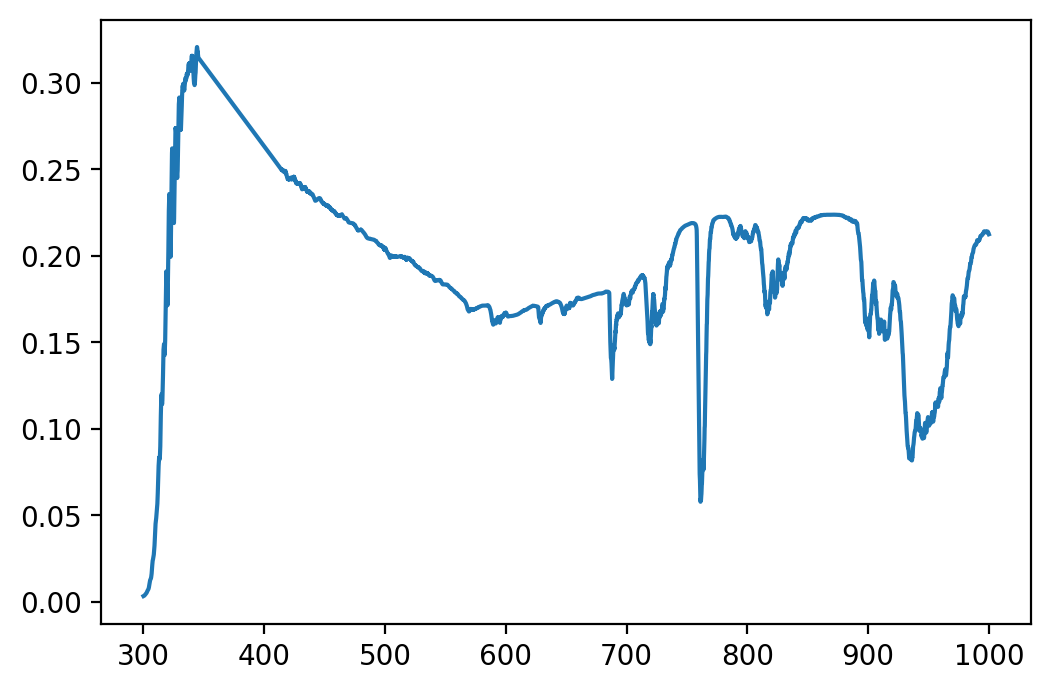

In [11]:
plt.figure()
plt.plot(lam_hr[mask], albedo_hr[mask])
plt.show()

In [17]:
np.sum(albedo_hr[mask])

4895.915541842979

# Optimal Resolution to Observe O2

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


750 775


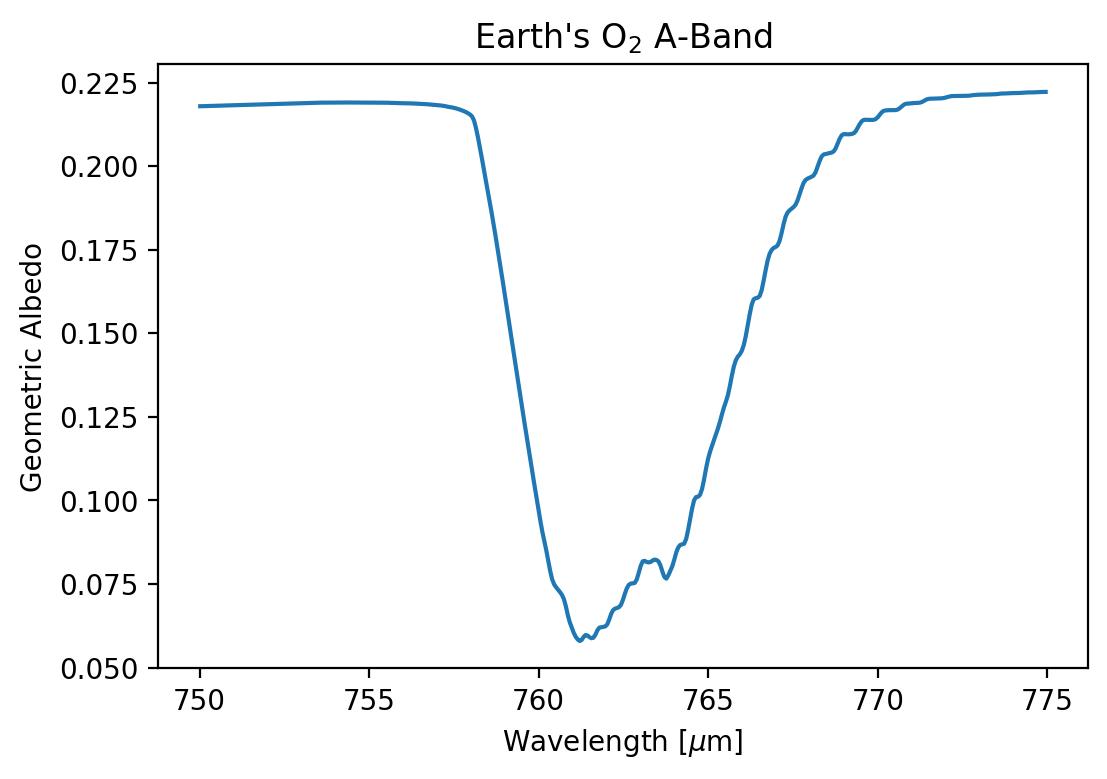

In [12]:
bw = 0.04
lam_c = 760
default = True
lammin = lam_c * (1-bw/2) if not default else 750
lammax = lam_c * (1+bw/2) if not default else 775
print(lammin, lammax)
# Create a wavelength mask
m = (lam_hr >= lammin) & (lam_hr <= lammax)

# Plot the band
plt.plot(lam_hr[m], albedo_hr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

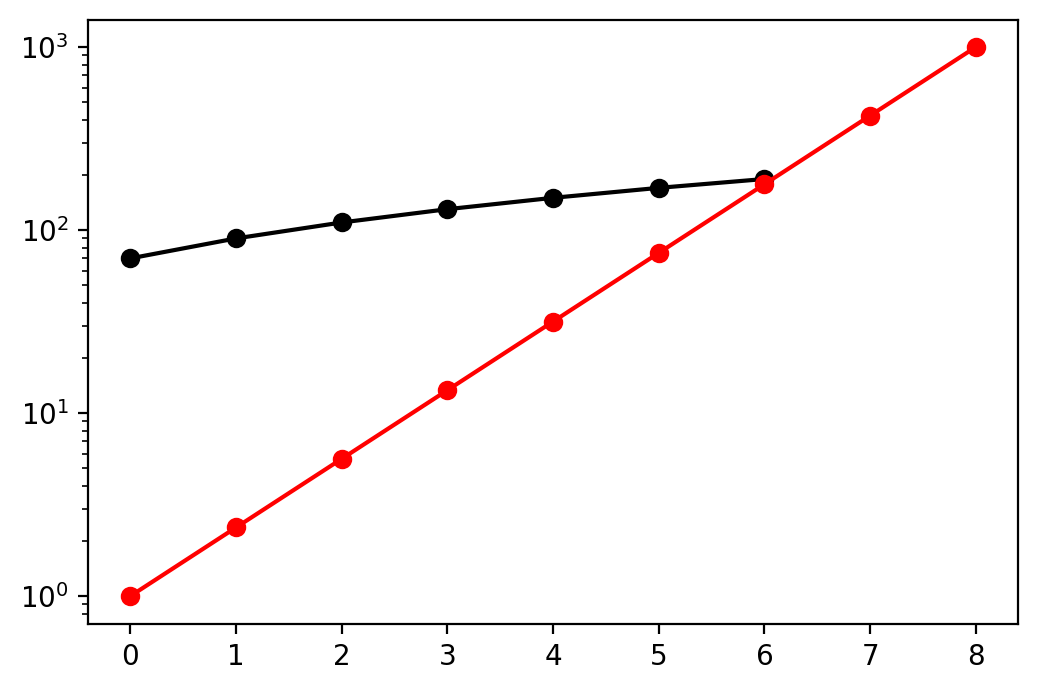

In [148]:
# Define a set of resolving powers to loop over
R = np.array([1, 10, 30, 70, 100, 150, 200, 500, 1000])
R_test = np.geomspace(1,1000,len(R_test))
R= np.arange(70,210, 20)
# R = 10**np.sqrt(np.linspace(0,3, len(R_test)))
plt.plot(R, 'k-o')
plt.plot(R_test, 'r-o')
plt.yscale('log')

In [49]:
def construct_lam(lammin, lammax, Res=None, dlam=None):
    # Keyword catching logic
    goR = False
    goL = False
    if ((Res is None) and (dlam is None)) or (Res is not None) and (dlam is not None):
        print("Error in construct_lam: Must specify either Res or dlam, but not both")
    elif Res is not None:
        goR = True
    elif dlam is not None:
        goL = True
    else:
        print("Error in construct_lam: Should not enter this else statment! :)")
        return None, None

    # If Res is provided, generate equal resolving power wavelength grid
    if goR:

        # Set wavelength grid
        dlam0 = lammin/Res
        dlam1 = lammax/Res
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax +dlam1):
            lam  = lam + lam/Res
            Nlam +=1
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
        Nlam = len(lam)
        dlam = np.zeros(Nlam) #grid widths (um)
#         print(lam)
        # Set wavelength widths
        for j in range(1,Nlam-1):
            dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])

        #Set edges to be same as neighbor
        dlam[0] = dlam0#dlam[1]
        dlam[Nlam-1] = dlam1#dlam[Nlam-2]

        lam = lam[:-1]
        dlam = dlam[:-1]

    # If dlam is provided, generate evenly spaced grid
    if goL:
        lam = np.arange(lammin, lammax+dlam, dlam)
        dlam = dlam + np.zeros_like(lam)

    return lam, dlam

In [50]:
from scipy.stats import binned_statistic
def downbin_spec(specHR, lamHR, lamLR, dlam=None):
    """
    Re-bin spectum to lower resolution using :py:obj:`scipy.binned_statistic`
    with ``statistic = 'mean'``. This is a "top-hat" convolution.
    Parameters
    ----------
    specHR : array-like
        Spectrum to be degraded
    lamHR : array-like
        High-res wavelength grid
    lamLR : array-like
        Low-res wavelength grid
    dlam : array-like, optional
        Low-res wavelength width grid
    Returns
    -------
    specLR : :py:obj:`numpy.ndarray`
        Low-res spectrum
    """

    if dlam is None:
        ValueError("Please supply dlam in downbin_spec()")

    # Reverse ordering if wl vector is decreasing with index
    if len(lamLR) > 1:
        if lamHR[0] > lamHR[1]:
            lamHI = np.array(lamHR[::-1])
            spec = np.array(specHR[::-1])
        if lamLR[0] > lamLR[1]:
            lamLO = np.array(lamLR[::-1])
            dlamLO = np.array(dlam[::-1])

    # Calculate bin edges
    LRedges = np.hstack([lamLR - 0.5*dlam, lamLR[-1]+0.5*dlam[-1]])

    # Call scipy.stats.binned_statistic()
    specLR = binned_statistic(lamHR, specHR, statistic="mean", bins=LRedges)[0]

    return specLR

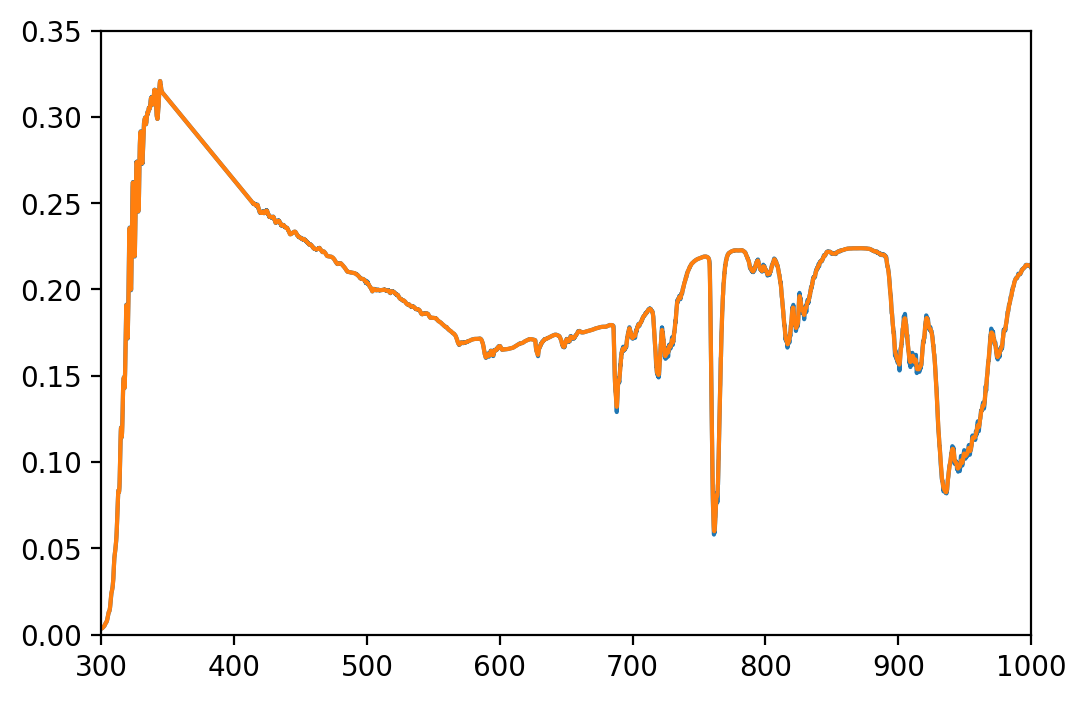

In [167]:
from scipy.ndimage import gaussian_filter1d
def gauss_smooth(lamref, R):
    sigma = lamref/R/2.355
    wl, dwl = construct_lam(300, 1000, R)
    albedo_smooth = gaussian_filter1d(albedo_hr, sigma, mode='nearest')
    albedo_binned = downbin_spec(albedo_hr, lam_hr, wl, dlam=dwl)
    
    plt.plot(lam_hr, albedo_hr)
    plt.plot(lam_hr, albedo_smooth)
#     plt.plot(wl, albedo_binned)
    plt.xlim([300,1000])
    plt.ylim(0, 0.35)
    return wl, albedo_binned

def gauss_smooth(lamref, R):
    sigma = lamref/R/2.355
    wl, dwl = construct_lam(300, 1000, R)
    albedo_smooth = np.exp(-4 * np.log(2) * R**2 * (lam/lamref - 1)**2)
    albedo_binned = downbin_spec(albedo_hr, lam_hr, wl, dlam=dwl)
    
    plt.plot(lam_hr, albedo_hr)
    plt.plot(lam_hr, albedo_smooth)
#     plt.plot(wl, albedo_binned)
    plt.xlim([300,1000])
    plt.ylim(0, 0.35)
    return wl, albedo_binned


lam_lr, albedo_lr = gauss_smooth(550, 50)
# plt.plot(lam_lr, albedo_lr)

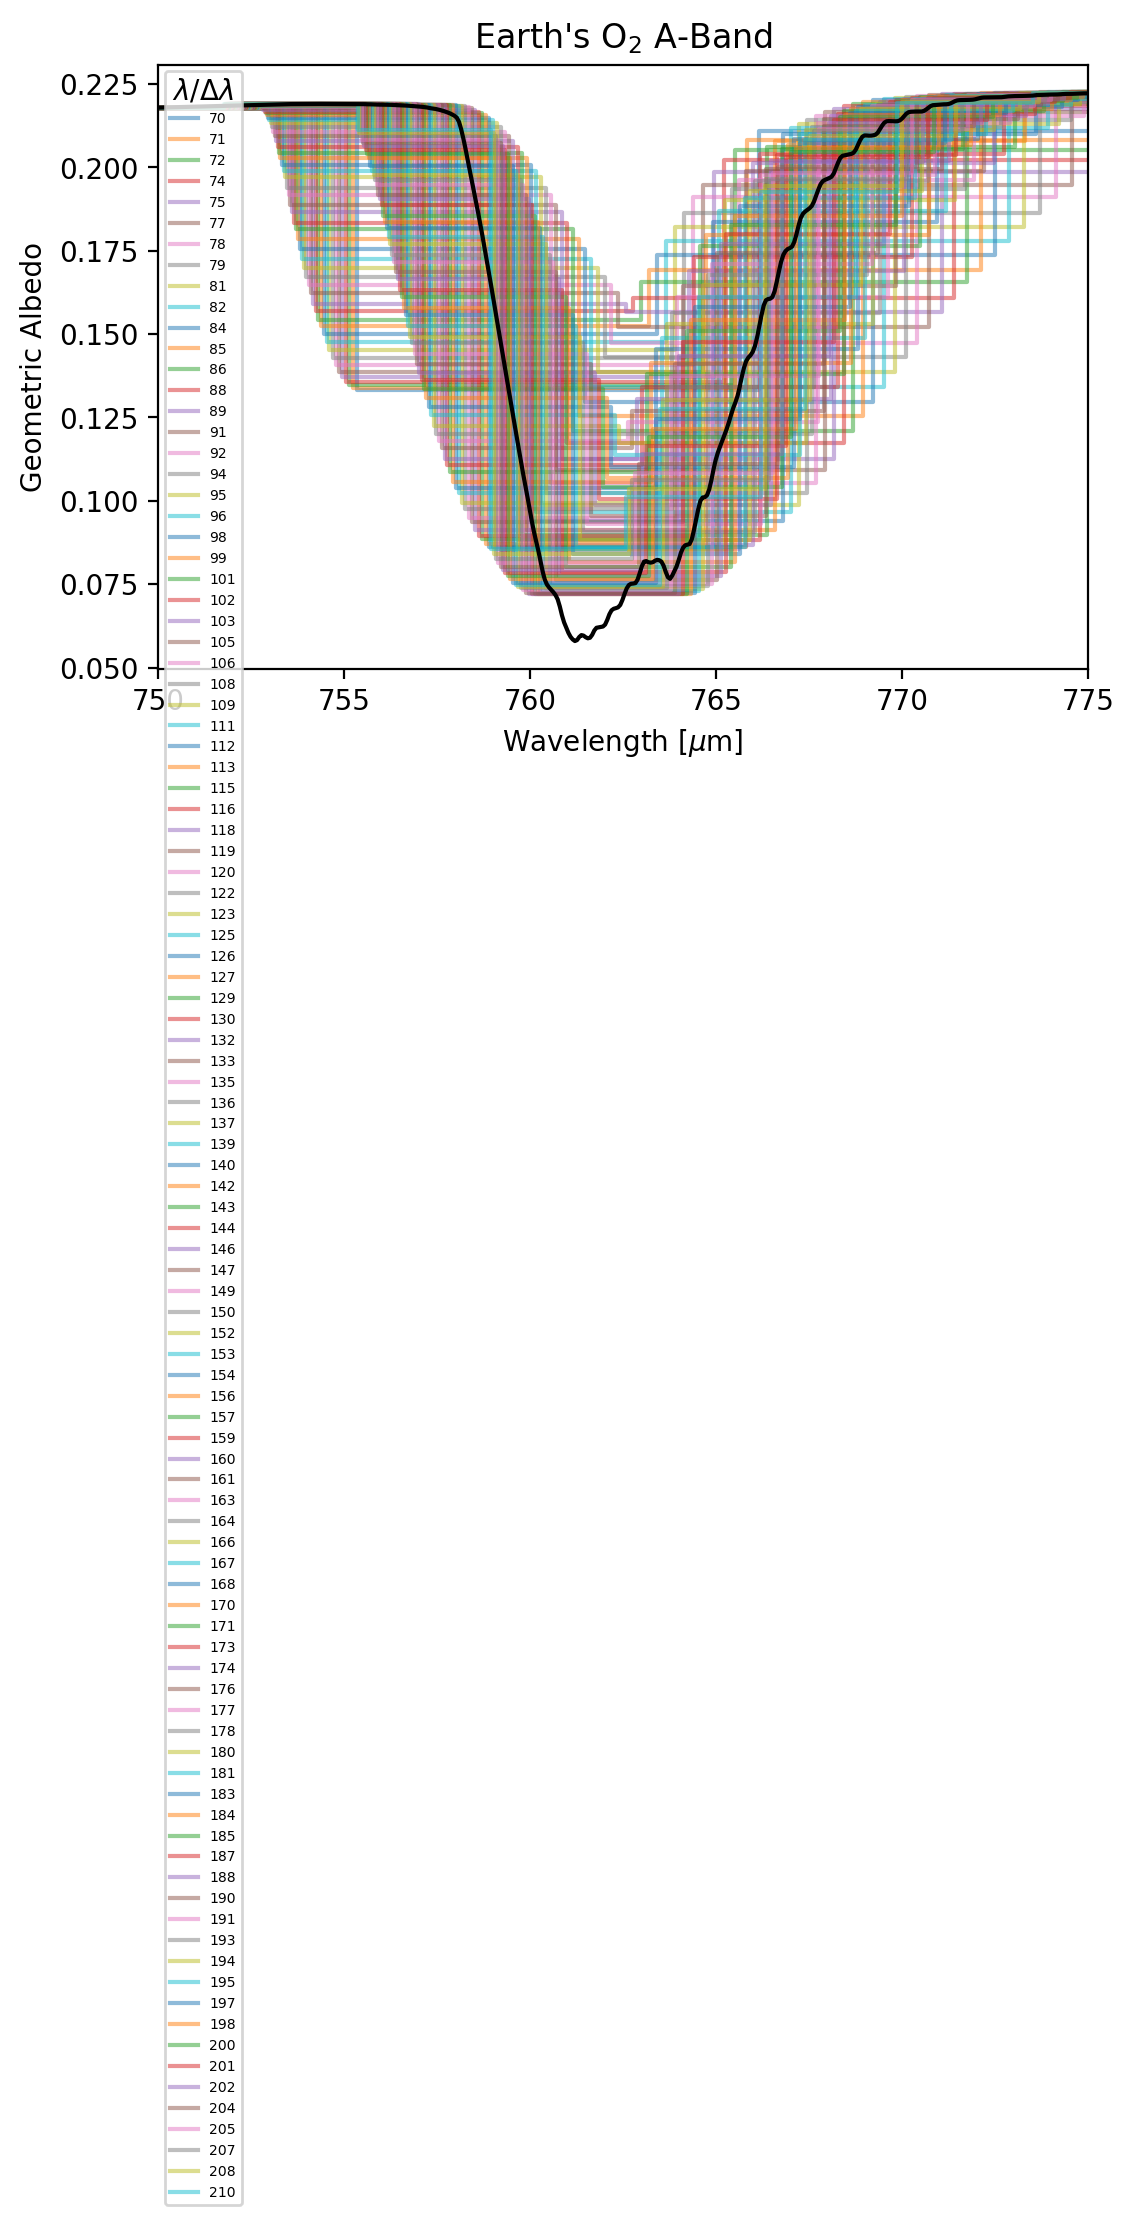

In [129]:
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    # Construct new low-res wavelength grid
    wl, dwl = construct_lam(lammin, lammax, r)
#     print(len(wl))
    # Down-bin flux to low-res
    albedo = downbin_spec(albedo_hr, lam_hr, wl, dlam=dwl)

    # Plot
    plt.step(wl, albedo, where='mid', alpha = 0.5, label = "%i" %r)

    # Save bottom value
    bottom_val[i] = np.min(albedo)

# Finsh plot
plt.plot(lam_hr[m], albedo_hr[m], c = "k")
plt.xlim(lammin, lammax)
plt.legend(fontsize = 5, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

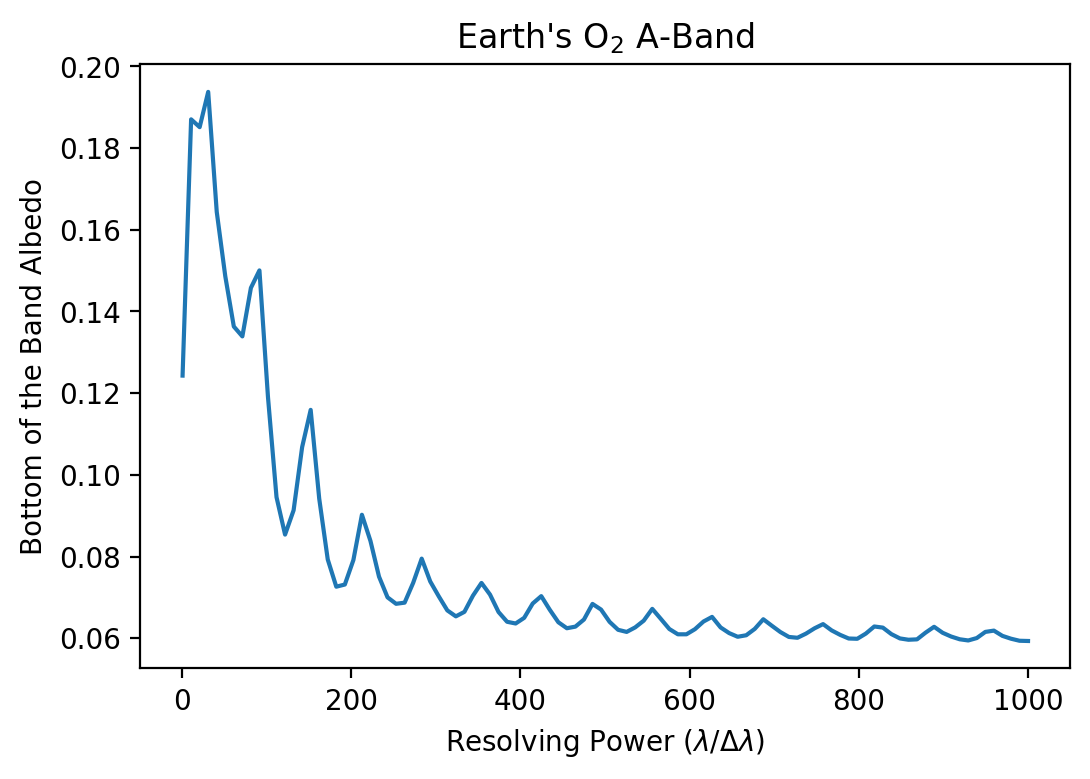

In [104]:
# Create resolution array to loop over
Nres = 100
R = np.linspace(1,1000, Nres)

# Array to store bottom-of-band albedos
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    # Construct new low-res wavelength grid
    wl, dwl = construct_lam(lammin, lammax, r)

    # Down-bin flux to low-res
    Alr = downbin_spec(albedo_hr, lam_hr, wl, dlam=dwl)

    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Make plot
plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band");

The oscillations in the above plot are the result of non-optimal placement of the resolution element relative to the oxygen A-band central wavelength. We can do better than this by iterating over different minimum wavelength positions.

<ipython-input-105-83c3a1974147>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
<ipython-input-105-83c3a1974147>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lams = np.array(lams).reshape((Ntest, Nres), order = 'F')


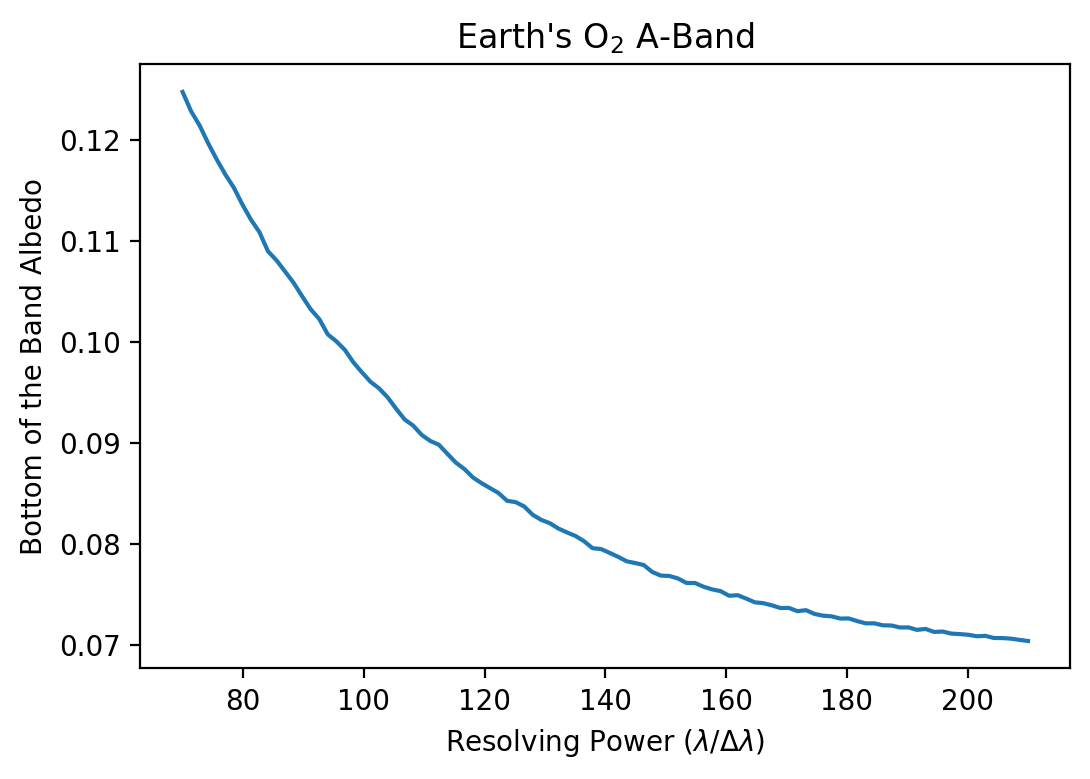

In [105]:
# Create resolution array to loop over
Nres = 100
R = np.linspace(2,1000, Nres)
R = np.linspace(70,210, Nres)
# Set number of initial positions
Ntest = 20

# Arrays to save quantities
bottom_vals = np.nan*np.zeros([len(R), Ntest])
best = np.nan*np.zeros(len(R), dtype=int)
Alrs = []
lams = []

# Loop over R
for i, r in enumerate(R):

    # Set grid of minimum wavelengths to iterate over
    lammin_vals = np.linspace(lammin - 1.0*lam_c/r, lammin, Ntest)

    # Loop over minimum wavelengths to adjust bin centers
    for j, lmin in enumerate(lammin_vals):

        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lmin, lammax, r)

        # Down-bin flux to low-res
        Alr = downbin_spec(albedo_hr, lam_hr, wl, dlam=dwl)

        # Keep track of the minimum
        if ~np.isfinite(best[i]) or (np.nansum(np.min(Alr) < bottom_vals[i,:]) > 0):
            best[i] = j

        # Save quantities
        bottom_vals[i,j] = np.min(Alr)
        Alrs.append(Alr)
        lams.append(wl)

# Reshape saved arrays
Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
lams = np.array(lams).reshape((Ntest, Nres), order = 'F')
best =  np.array(best, dtype=int)

# Plot the global minimum
plt.plot(R, np.min(bottom_vals, axis = 1));
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band");

In [95]:
lams

array([[array([370. , 555. , 832.5]),
        array([687.090301  , 743.96483261, 805.54720588]),
        array([715.7064722 , 748.00134036, 781.75345189]), ...,
        array([749.22436188, 749.98900264, 750.75442377, 751.52062607,
               752.28761034, 753.05537737, 753.82392797, 754.59326293,
               755.36338306, 756.13428916, 756.90598202, 757.67846246,
               758.45173127, 759.22578926, 760.00063724, 760.77627601,
               761.55270638, 762.32992915, 763.10794514, 763.88675515,
               764.66636   , 765.4467605 , 766.22795745, 767.00995167,
               767.79274398, 768.57633519, 769.36072612, 770.14591757,
               770.93191037, 771.71870534, 772.5063033 , 773.29470505,
               774.08391143, 774.87392326, 775.66474135])             ,
        array([749.23226057, 749.98912261, 750.74674922, 751.50514117,
               752.26429924, 753.0242242 , 753.78491682, 754.54637788,
               755.30860815, 756.07160842, 756.83537946, 

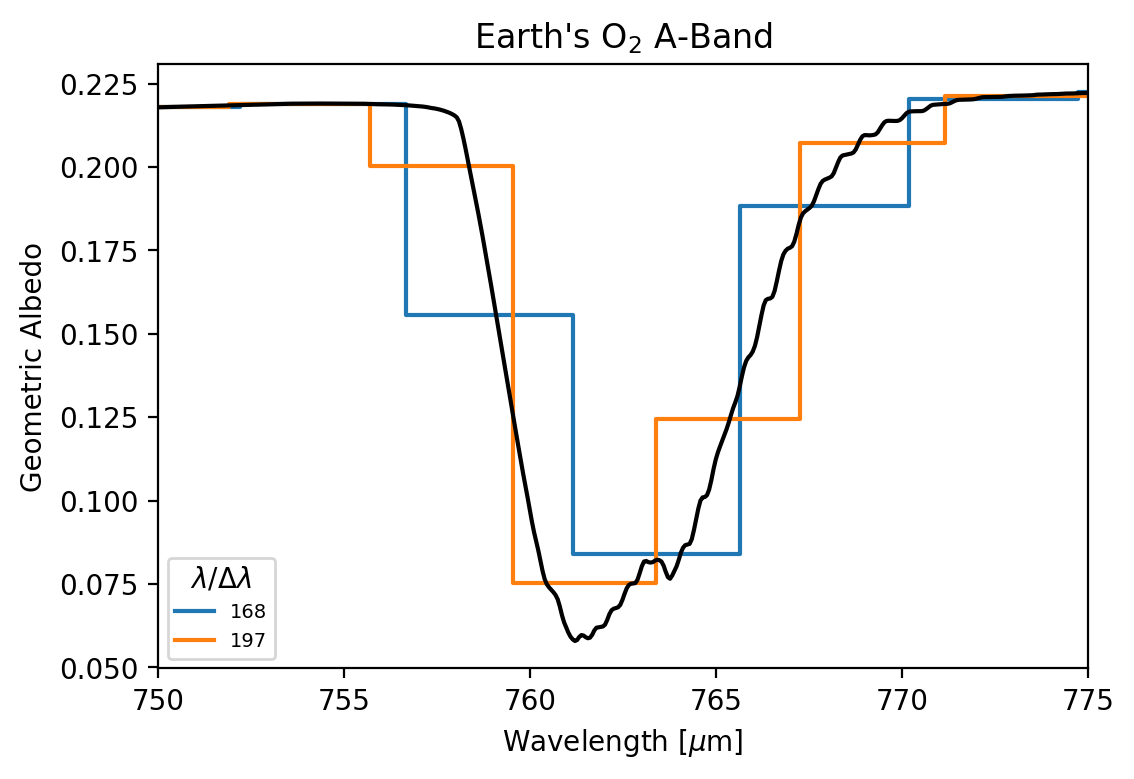

In [107]:

# Get some log-spaced indices so we're not plotting all R
iz = np.array(np.logspace(np.log10(1), np.log10(100), 10).round(), dtype=int) - 1

colors = None
# Loop over R
for i, r in enumerate(R):
  # Plot some of the resolutions
    if i in iz:
        
        wlens = lams[best[i], i]
        alb = Alrs[best[i], i]
        
        plt.plot(wlens, alb,  drawstyle='steps-mid', alpha = 0.5*2, label=f'{int(r)}')
#     # Plot some of the resolutions
#     if i in iz:
#         plt.step(lams[best[i], i], Alrs[best[i], i],where='mid', alpha = 0.5, label = "%i" %r)
#         plt.xlim(lammin, lammax)
plt.xlim(lammin, lammax)
# Finsh plot
plt.plot(lam_hr[m], albedo_hr[m], c = "k")
plt.legend(fontsize = 7, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

In [8]:
def construct_lam_ifs(lammin, lammax, R, verbose=True):
     
    log_lammin = np.log(float(lammin)).astype(np.float64)
    log_lammax = np.log(float(lammax))
    Nspec = int(np.log(lammax/lammin) * R) + 1
    
    dloglam = (log_lammax - log_lammin) / Nspec
    
    if verbose:
        print('Reduced cube will have %d wavelength bins' % (Nspec))
#     print(np.exp(log_lammin))
#     print(np.exp(log_lammax))
    
#     loglam_midpts = np.arange(log_lammin, log_lammax + dloglam, dloglam)
#     loglam_endpts = calculate_bin_edges(loglam_midpts)
    loglam_midpts = np.linspace(log_lammin, log_lammax, Nspec)
    loglam_endpts = calculate_bin_edges(loglam_midpts)
    
#     loglam_endpts = np.linspace(log_lammin, log_lammax, Nspec)
#     loglam_midpts = (loglam_endpts[1:] + loglam_endpts[:-1]) / 2
    lam_endpts = np.exp(loglam_endpts)
    lam_midpts = np.exp(loglam_midpts)
    
#     print(lam_midpts.size, lam_midpts[:-1] / np.diff(lam_midpts))
#     dlam = (lammax - lammin) / Nspec
#     lam_midpts = np.arange(lammin, lammax + dlam, dlam)
#     lam_endpts = calculate_bin_edges(lam_midpts)
    return lam_midpts, lam_endpts

In [67]:
def construct_lam(lammin, lammax, Res=None, dlam=None):
    # Keyword catching logic
    goR = False
    goL = False
    if ((Res is None) and (dlam is None)) or (Res is not None) and (dlam is not None):
        print("Error in construct_lam: Must specify either Res or dlam, but not both")
    elif Res is not None:
        goR = True
    elif dlam is not None:
        goL = True
    else:
        print("Error in construct_lam: Should not enter this else statment! :)")
        return None, None

    # If Res is provided, generate equal resolving power wavelength grid
    if goR:

        # Set wavelength grid
        dlam0 = lammin/Res
        dlam1 = lammax/Res
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax + dlam1):
            lam  = lam + lam/Res
            Nlam +=1
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
        Nlam = len(lam)
        dlam = np.zeros(Nlam) #grid widths (um)
#         print(lam)
        # Set wavelength widths
        for j in range(1,Nlam-1):
            dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])

        #Set edges to be same as neighbor
        dlam[0] = dlam0#dlam[1]
        dlam[Nlam-1] = dlam1#dlam[Nlam-2]

        lam = lam[:-1]
        dlam = dlam[:-1]

    # If dlam is provided, generate evenly spaced grid
    if goL:
        lam = np.arange(lammin, lammax+dlam, dlam)
        dlam = dlam + np.zeros_like(lam)

    return lam, dlam

In [10]:
def construct_lam_chris(lammin, lammax, R, verbose=True):
    dloglam = 1.0 / 500.0
    loglam_min = np.log(300)
    loglam_max = np.log(1000)
    nlam = int(np.ceil((loglam_max - loglam_min)/dloglam))+1
    if verbose:
        print('Reduced cube will have %d wavelength bins' % (nlam))
    loglam_arr = np.arange(nlam, dtype=np.float64) / (nlam-1) * (loglam_max - loglam_min) + loglam_min
    lam = np.exp(loglam_arr)
    return lam

In [11]:
from scipy.stats import binned_statistic
def downbin_spec(specHR, lamHR, lamLR, dlam=None):
    """
    Re-bin spectum to lower resolution using :py:obj:`scipy.binned_statistic`
    with ``statistic = 'mean'``. This is a "top-hat" convolution.
    Parameters
    ----------
    specHR : array-like
        Spectrum to be degraded
    lamHR : array-like
        High-res wavelength grid
    lamLR : array-like
        Low-res wavelength grid
    dlam : array-like, optional
        Low-res wavelength width grid
    Returns
    -------
    specLR : :py:obj:`numpy.ndarray`
        Low-res spectrum
    """

    if dlam is None:
        ValueError("Please supply dlam in downbin_spec()")

    # Reverse ordering if wl vector is decreasing with index
    if len(lamLR) > 1:
        if lamHR[0] > lamHR[1]:
            lamHI = np.array(lamHR[::-1])
            spec = np.array(specHR[::-1])
        if lamLR[0] > lamLR[1]:
            lamLO = np.array(lamLR[::-1])
            dlamLO = np.array(dlam[::-1])

    # Calculate bin edges
    LRedges = np.hstack([lamLR - 0.5*dlam, lamLR[-1]+0.5*dlam[-1]])

    # Call scipy.stats.binned_statistic()
    specLR = binned_statistic(lamHR, specHR, statistic="mean", bins=LRedges)[0]

    return specLR

def downbin_spec_ifs(lam_new, lam_bins, spec):
    # Call scipy.stats.binned_statistic()
    spec_new = binned_statistic(lam_new, spec, statistic="mean", bins=lam_bins)[0]
    return spec_new

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


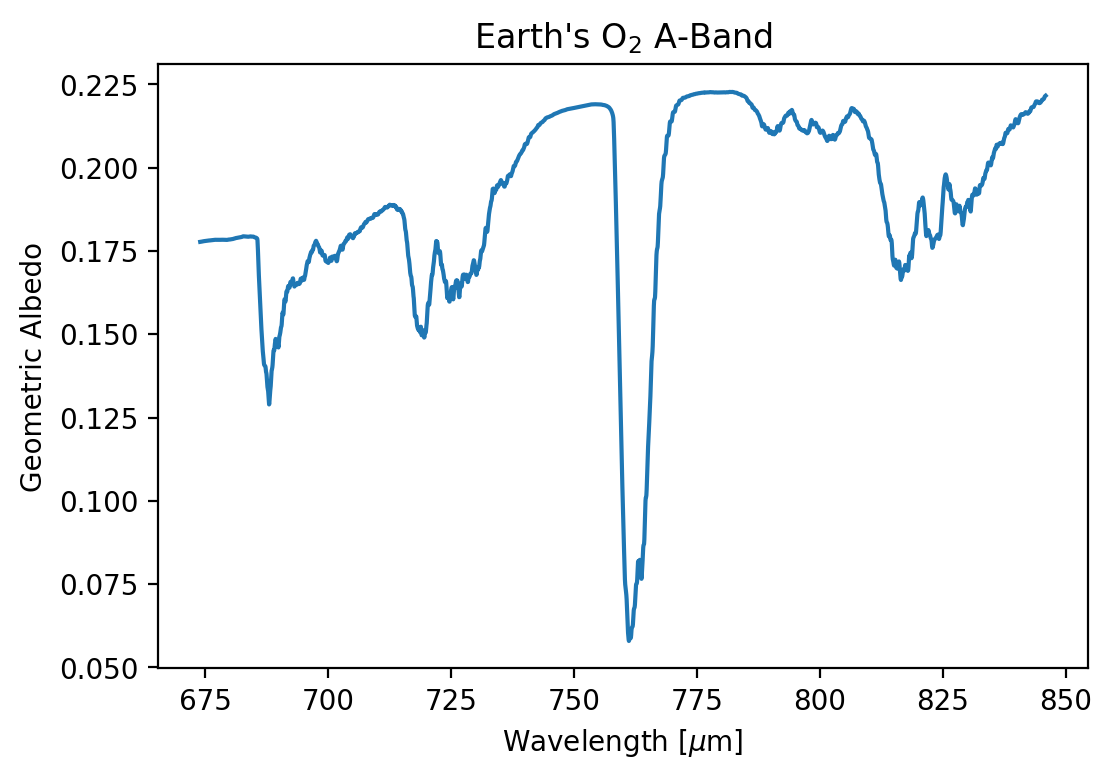

In [12]:
lammin = 684.0 - 10.0
lammax = 836.0 + 10.0

# Create a wavelength mask
m = (lam > lammin) & (lam < lammax)

# Plot the band
plt.plot(lam[m], albedo[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

In [13]:
# define set of resolving powers
R = np.array([1, 10, 30, 70, 100, 150, 200, 500])
R = np.arange(70, 190, 20)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


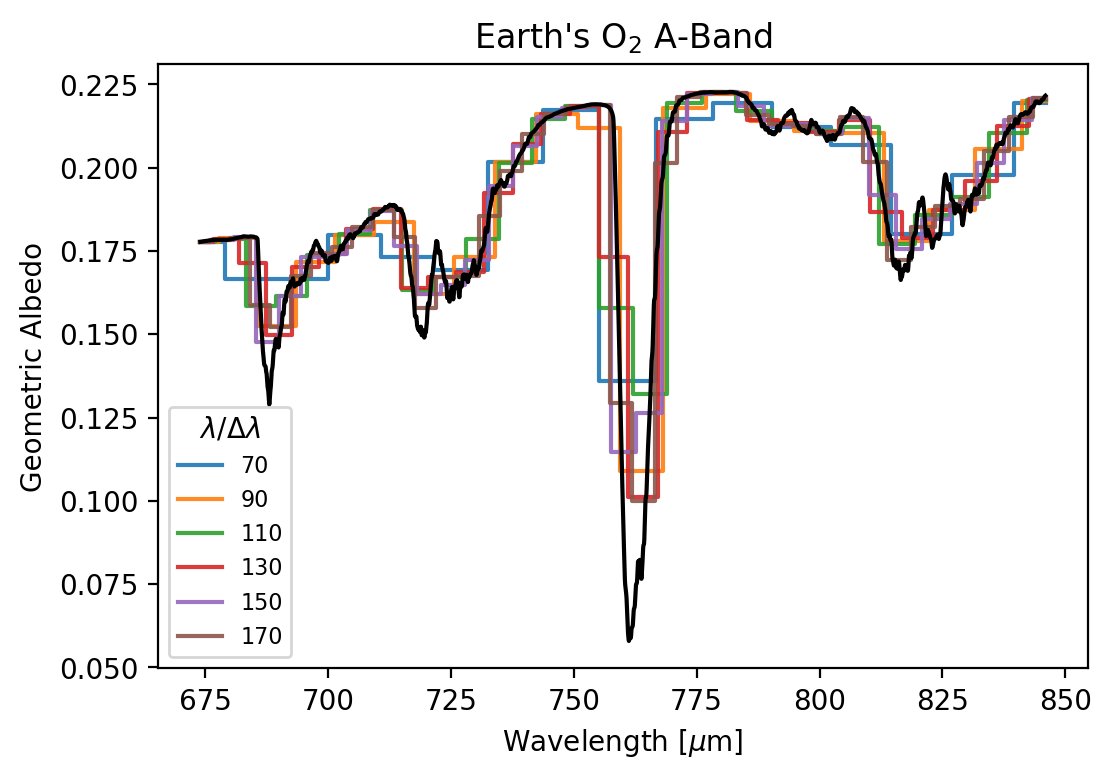

In [14]:
ifs = True
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Plot
#     plt.step(wl, Alr, where="mid", alpha = 0.5, color=f"C{i}", label = "%i" %r)
    plt.plot(wl, Alr, drawstyle='steps-mid', alpha = 0.9, color=f"C{i}", label = "%i" %r)
#     plt.scatter(wl, Alr, color=f"C{i}")

    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Finsh plot
plt.plot(lam[m], albedo[m], c = "k")
# plt.xlim(lammin, lammax)
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

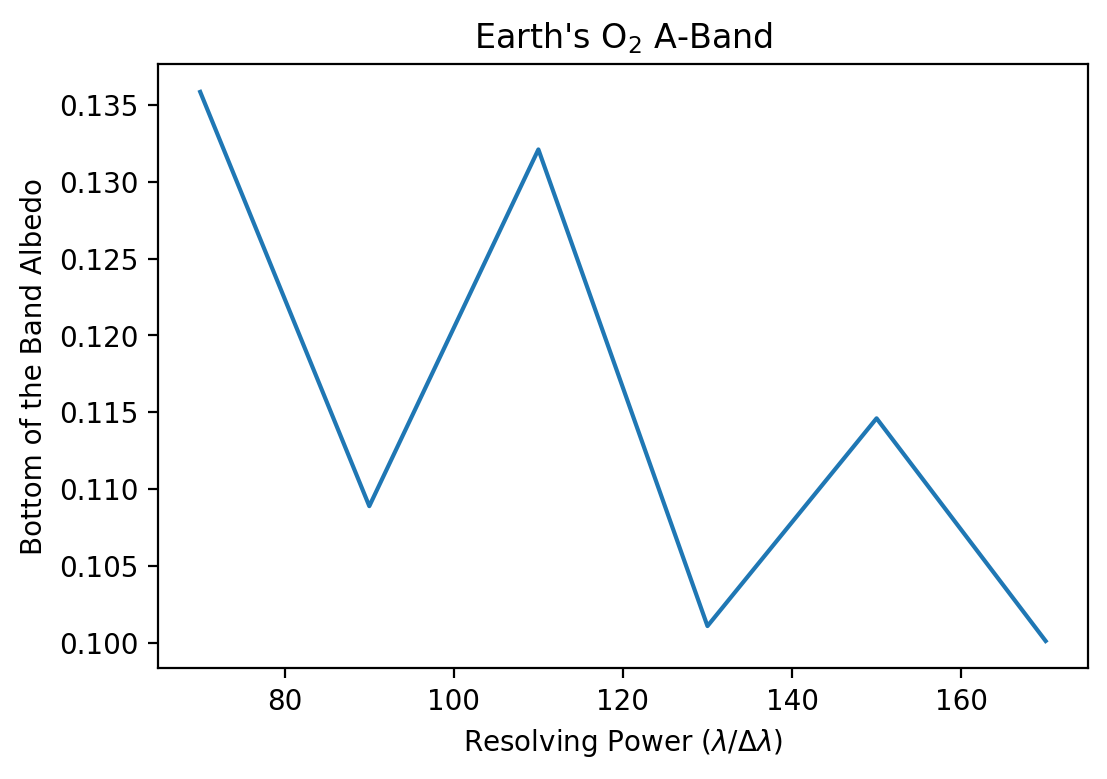

In [15]:

# Create resolution array to loop over
Nres = 100
R = np.linspace(2,1000,Nres)

R = np.arange(70, 190, 20)
Nres = len(R)
# Array to store bottom-of-band albedos
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):

    # Construct new low-res wavelength grid
    if ifs:
        wl, dwl = construct_lam_ifs(lammin, lammax, r, verbose=False)
#         print(wl.size, dwl.size)
        Alr = downbin_spec_ifs(lam, dwl, albedo)
    else:                               
        # Construct new low-res wavelength grid
        wl, dwl = construct_lam(lammin, lammax, r)
        #     print(wl)
        # Down-bin flux to low-res
        Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

    # Save bottom value
    bottom_val[i] = np.min(Alr)


# Make plot
plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band")
plt.show()

<ipython-input-19-4d6547ddcc10>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
<ipython-input-19-4d6547ddcc10>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lams = np.array(lams).reshape((Ntest, Nres), order = 'F')


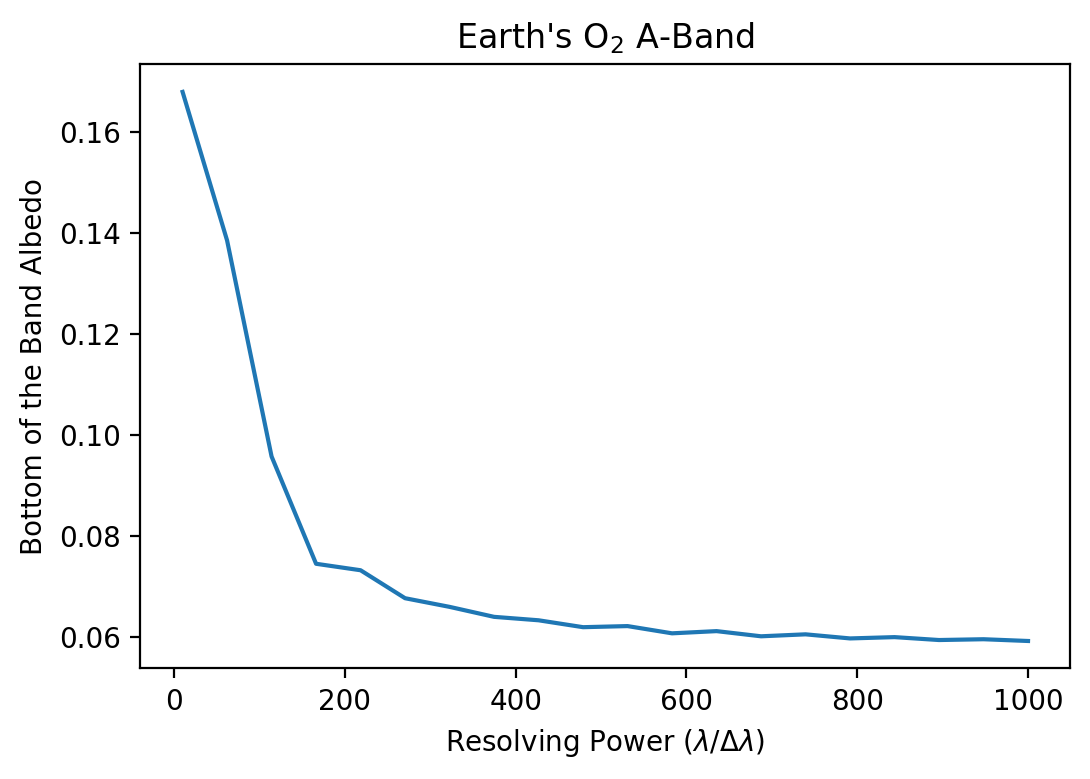

In [19]:
# Create resolution array to loop over
Nres = 20
R = np.linspace(10,1000, Nres)

# R = np.arange(70, 190, 20)
Nres = len(R)
# Set number of initial positions
Ntest = 1000

# Arrays to save quantities
bottom_vals = np.nan*np.zeros([len(R), Ntest])
best = np.nan*np.zeros(len(R), dtype=int)
Alrs = []
lams = []

# Loop over R
for i, r in enumerate(R):

    # Set grid of minimum wavelengths to iterate over
    lammin_vals = np.linspace(lammin - lammin/r, lammin+lammin/r, Ntest)

    # Loop over minimum wavelengths to adjust bin centers
    for j, lmin in enumerate(lammin_vals):

        if ifs:
            wl, dwl = construct_lam_ifs(lmin, lammax, r, verbose=False)
#             print(wl.size, dwl.size)
            Alr = downbin_spec_ifs(lam, dwl, albedo)
        else:                               
            # Construct new low-res wavelength grid
            wl, dwl = construct_lam(lmin, lammax, r)
            #     print(wl)
            # Down-bin flux to low-res
            Alr = downbin_spec(albedo,lam, wl, dlam=dwl)

        # Keep track of the minimum
        is_best = ~np.isfinite(best[i]) or (np.nansum(np.min(Alr) < bottom_vals[i,:]) > 0)
 
        if is_best:
            best[i] = j

        # Save quantities
        bottom_vals[i,j] = np.min(Alr)
        Alrs.append(Alr)
        lams.append(wl)
#     print(wl)
# Reshape saved arrays
Alrs = np.array(Alrs).reshape((Ntest, Nres), order = 'F')
lams = np.array(lams).reshape((Ntest, Nres), order = 'F')
best =  np.array(best, dtype=int)

# Plot the global minimum
plt.plot(R, np.min(bottom_vals, axis = 1));
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
# plt.xlim([100, 500])
plt.title(r"Earth's O$_2$ A-Band");

[0 0 1 1 2 3 4 5 7 9]
693.767967967968 845.9999999999998
684.8525423728814 845.9999999999998
679.9013824884795 845.9999999999998
678.0525316455695 845.9999999999998
677.0857831325303 845.9999999999998
676.491439688716 845.9999999999998
675.7985955056181 845.9999999999998
675.4072527472528 845.9999999999998
8


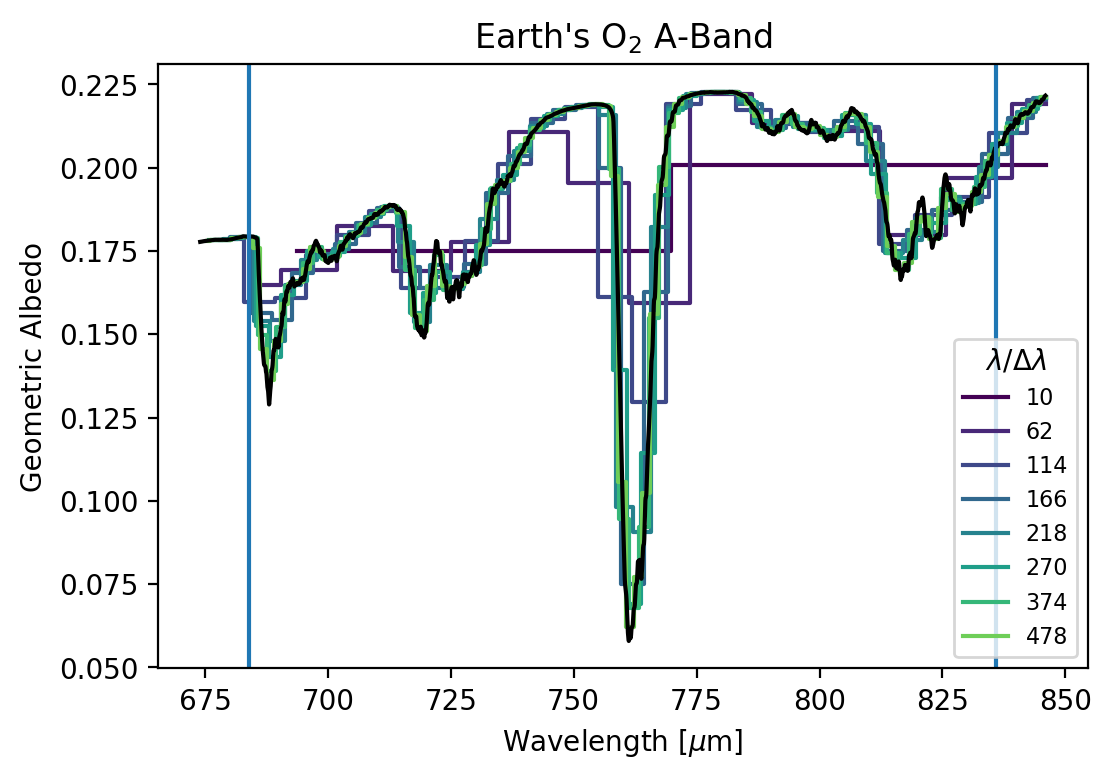

In [20]:

# Get some log-spaced indices so we're not plotting all R
iz = np.array(np.logspace(np.log10(1), np.log10(10), 10).round(), dtype=int) - 1
print(iz)
colors = plt.cm.viridis(np.linspace(0,1, 10))
# Loop over R
count = 0
for i, r in enumerate(R):

    
    # Plot some of the resolutions
    if i in iz:
        
        wlens = lams[best[i], i]
        alb = Alrs[best[i], i]
        
        plt.plot(wlens, alb,  drawstyle='steps-mid', alpha = 0.5*2, color=colors[count], label=f'{int(r)}')
        print(wlens.min(), wlens.max())
        count +=1
#         plt.scatter(wl, Alr, color=f"C{i}")
#         plt.plot(lams[best[i], i], Alrs[best[i], i], ls = "steps-mid", alpha = 0.5, label = "%i" %r)
print(count)

# Finsh plot
plt.plot(lam[m], albedo[m], c = "k")
plt.legend(fontsize = 8, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
# plt.xlim(0.9*lammin, 1.1*lammax)
# plt.axvline(719)
plt.title(r"Earth's O$_2$ A-Band");
plt.axvline(684)
plt.axvline(836)

In [144]:
def new_construct_lam(lammin, lammax, lamref, R, verbose=True):
    dloglam = 1.0 / R
    loglam_ref = np.log(lamref)
    loglam_min = np.log(lammin)
    loglam_max = np.log(lammax)
    
    
    nlam = int(np.ceil((loglam_max - loglam_min)/dloglam))+1
    
    nlam = int(np.ceil(np.log(lammax/lammin) * R)) 
    dloglam = (loglam_max - loglam_min) / (nlam)
    
#     dloglam = np.log(lammax/lammin)/nlam
    print(dloglam, np.log(lammax/lammin)/nlam)
    
    if verbose:
        print('Reduced cube will have %d wavelength bins' % (nlam))
        
    loglam_1 = loglam_ref - np.arange(nlam, dtype=np.float64) * dloglam#/ (nlam-1) * (loglam_max - loglam_min) 
    loglam_2 = loglam_ref + np.arange(nlam, dtype=np.float64) * dloglam#/ (nlam-1) * (loglam_max - loglam_min)
    loglam_arr = np.concatenate([np.flip(loglam_1)[:-1], loglam_2])

#     loglam_arr = np.arange(nlam, dtype=np.float64) / (nlam-1) * (loglam_max - loglam_min) + loglam_min
    lam = np.exp(loglam_arr)
    m = (lam >= lammin) & (lam<= lammax )
    return lam[m]

In [108]:
lam_test = new_construct_lam(lammin, lammax, 760, 300)
lam_test

0.003289683532166419 0.0032896835321664136
Reduced cube will have 61 wavelength bins


array([684.06200237, 686.3160554 , 688.57753576, 690.84646793,
       693.12287646, 695.40678598, 697.69822122, 699.99720696,
       702.30376809, 704.61792957, 706.93971645, 709.26915385,
       711.60626698, 713.95108113, 716.30362168, 718.66391409,
       721.0319839 , 723.40785673, 725.79155831, 728.18311442,
       730.58255095, 732.98989386, 735.40516921, 737.82840314,
       740.25962186, 742.6988517 , 745.14611904, 747.60145037,
       750.06487227, 752.53641139, 755.01609448, 757.50394838,
       760.        , 762.50427636, 765.01680457, 767.53761181,
       770.06672536, 772.6041726 , 775.14998098, 777.70417805,
       780.26679146, 782.83784894, 785.41737831, 788.00540749,
       790.60196449, 793.2070774 , 795.82077442, 798.44308384,
       801.07403403, 803.71365346, 806.3619707 , 809.01901442,
       811.68481336, 814.35939638, 817.04279242, 819.73503051,
       822.43613981, 825.14614952, 827.865089  , 830.59298765,
       833.329875  ])

In [102]:
lam_test[:-1]  / np.diff(lam_test)

array([303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207,
       303.48088207, 303.48088207, 303.48088207, 303.48088207])

In [47]:
def construct_lam(lammin, lammax, Res=None, dlam=None):
    # Keyword catching logic
    goR = False
    goL = False
    if ((Res is None) and (dlam is None)) or (Res is not None) and (dlam is not None):
        print("Error in construct_lam: Must specify either Res or dlam, but not both")
    elif Res is not None:
        goR = True
    elif dlam is not None:
        goL = True
    else:
        print("Error in construct_lam: Should not enter this else statment! :)")
        return None, None

    # If Res is provided, generate equal resolving power wavelength grid
    if goR:

        # Set wavelength grid
        dlam0 = lammin/Res
        dlam1 = lammax/Res
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax + dlam1):
            lam  = lam + lam/Res
            Nlam +=1
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
        Nlam = len(lam)
        dlam = np.zeros(Nlam) #grid widths (um)
#         print(lam)
        # Set wavelength widths
        for j in range(1,Nlam-1):
            dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])

        #Set edges to be same as neighbor
        dlam[0] = dlam0#dlam[1]
        dlam[Nlam-1] = dlam1#dlam[Nlam-2]

        lam = lam[:-1]
        dlam = dlam[:-1]

    # If dlam is provided, generate evenly spaced grid
    if goL:
        lam = np.arange(lammin, lammax+dlam, dlam)
        dlam = dlam + np.zeros_like(lam)

    return lam, dlam

In [24]:
np.geomspace(0.01,1000, 11)

array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03])

In [56]:
def construct_lam_new(lammin, lammax, R):
    lnlammin = np.log(lammin * (1 - 1/R))
    lnlammax = np.log(lammax * (1 + 1/R))
    nlam = int(np.ceil((lnlammax - lnlammin) * R)) 
    loglam = np.arange(nlam) / (nlam-1) * (lnlammax - lnlammin) + lnlammin
    
#     loglam = np.linspace(lnlammin, lnlammax, nlam)
    return np.exp(loglam)

In [57]:
lam = construct_lam_new(684, 836, 150)

In [58]:
lam

array([679.44      , 683.99907244, 688.58873646, 693.20919733,
       697.8606617 , 702.5433376 , 707.25743446, 712.00316312,
       716.78073582, 721.59036626, 726.43226952, 731.30666217,
       736.21376221, 741.15378911, 746.12696381, 751.13350873,
       756.17364778, 761.24760639, 766.35561149, 771.49789153,
       776.6746765 , 781.88619792, 787.13268888, 792.41438403,
       797.73151959, 803.08433336, 808.47306474, 813.89795476,
       819.35924602, 824.85718279, 830.39201096, 835.96397808,
       841.57333333])

In [59]:
lam[:-1] / np.diff(lam)

array([149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449,
       149.03031449, 149.03031449, 149.03031449, 149.03031449])

In [65]:
for r in np.arange(10,1310,10):#np.ceil(np.geomspace(10, 500, 20)):
    lam = construct_lam_new(684, 836, r)
    r_test = lam[1:]/ np.diff(lam)
    print(r, r_test[0], len(lam))

10 10.474937185533122 5
20 20.45402610308877 7
30 30.424755581228595 9
40 40.39340652300954 11
50 50.361227352506035 13
60 60.328633429445254 15
70 70.2958026042878 17
80 80.2628237553164 19
90 90.2297462423241 21
100 100.19659967402993 23
110 110.16340288897958 25
120 120.13016844448279 27
130 130.09690503310338 29
140 140.0636188633004 31
150 150.03031448758787 33
160 159.9969953201373 35
170 169.96366397169243 37
180 179.9303224727043 39
190 189.89697242609145 41
200 199.86361511418147 43
210 209.8302515750064 45
220 219.79688265782477 47
230 229.76350906416334 49
240 239.73013137869316 51
250 249.69675009241843 53
260 259.6633656209275 55
270 269.62997831814033 57
280 279.5965884873671 59
290 289.5631963902578 61
300 299.5298022533942 63
310 309.4964062742342 65
320 319.4630086254036 67
330 329.42960945881714 69
340 339.3962089083135 71
350 349.3628070925944 73
360 359.329404117121 75
370 369.29600007583423 77
380 379.26259505295945 79
390 389.22918912396375 81
400 399.195782356787

In [63]:
np.arange(10,310,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300])

In [69]:
for r in np.arange(10,1310,10):#np.ceil(np.geomspace(10, 500, 20)):
    lam = construct_lam(684, 836, r)[0]
    r_test = lam[1:]/ np.diff(lam)
    print(r, r_test[0], len(lam))

10 11.000000000000004 4
20 20.999999999999975 6
30 31.00000000000006 8
40 40.99999999999995 10
50 51.000000000000185 12
60 61.00000000000012 14
70 70.99999999999979 16
80 81.00000000000043 18
90 90.99999999999973 20
100 100.99999999999953 22
110 110.99999999999949 24
120 120.99999999999905 26
130 131.00000000000134 28
140 141.00000000000122 30
150 151.0000000000018 32
160 161.00000000000085 34
170 171.0000000000009 36
180 181.00000000000216 38
190 190.9999999999988 40
200 201.0000000000024 42
210 210.99999999999937 44
220 220.99999999999898 46
230 231.0000000000043 48
240 240.9999999999981 50
250 251.0000000000009 52
260 260.99999999999704 54
270 271.00000000000324 56
280 280.9999999999959 58
290 291.000000000004 60
300 301.0000000000036 62
310 310.99999999999443 64
320 320.9999999999932 66
330 330.99999999999244 68
340 341.0000000000018 70
350 351.0000000000071 72
360 361.0000000000043 74
370 370.99999999999153 76
380 381.0000000000096 78
390 391.00000000001245 80
400 400.999999999991

In [ ]:
lams = []
lammin = 684
lammax = 836

while la

In [71]:
lams = np.zeros(10)
lams[0] = 684
R=150
for i in range(1,len(lams)):
    lams[i] = lams[i-1] + lams[i-1]/R

In [72]:
lams

array([684.        , 688.56      , 693.1504    , 697.77140267,
       702.42321202, 707.10603343, 711.82007365, 716.56554081,
       721.34264442, 726.15159538])

In [76]:
lams[:-1]/np.diff(lams)

array([150., 150., 150., 150., 150., 150., 150., 150., 150.])

In [104]:
def calculateWaveList(lammin, lammax, R):
    Nspec = int(np.log(lammax/lammin) * R  + 1)
#     lam_endpts = np.linspace(min(lamlist), max(lamlist), Nspec)
#     lam_midpts = (lam_endpts[1:]+lam_endpts[:-1])/2.
    loglam_endpts = np.linspace(np.log(lammin), np.log(lammax), Nspec)
    loglam_midpts = (loglam_endpts[1:] + loglam_endpts[:-1]) / 2
    lam_endpts = np.exp(loglam_endpts)
    lam_midpts = np.exp(loglam_midpts)
    
    lam_midpts = np.geomspace(lammin, lammax, Nspec)
    lam_midpts = np.exp(np.arange(Nspec) / (Nspec) * np.log(lammax/lammin) + np.log(lammin))
    return lam_midpts, lam_endpts

In [105]:
lams = calculateWaveList(684, 836, 150)[0]

In [106]:
lams

array([684.        , 688.44206358, 692.912975  , 697.41292162,
       701.94209199, 706.50067591, 711.08886439, 715.70684968,
       720.35482531, 725.03298603, 729.74152787, 734.48064813,
       739.2505454 , 744.05141956, 748.88347176, 753.7469045 ,
       758.64192156, 763.56872806, 768.52753045, 773.51853652,
       778.5419554 , 783.5979976 , 788.68687497, 793.80880076,
       798.96398959, 804.15265748, 809.37502185, 814.63130153,
       819.92171678, 825.24648929, 830.60584217])

In [109]:
lams[:-1]/np.diff(lams)

array([153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773, 153.98248773, 153.98248773,
       153.98248773, 153.98248773])

In [20]:
def gauss(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / np.sqrt(2 * np.pi * np.power(sig, 2))     

23334


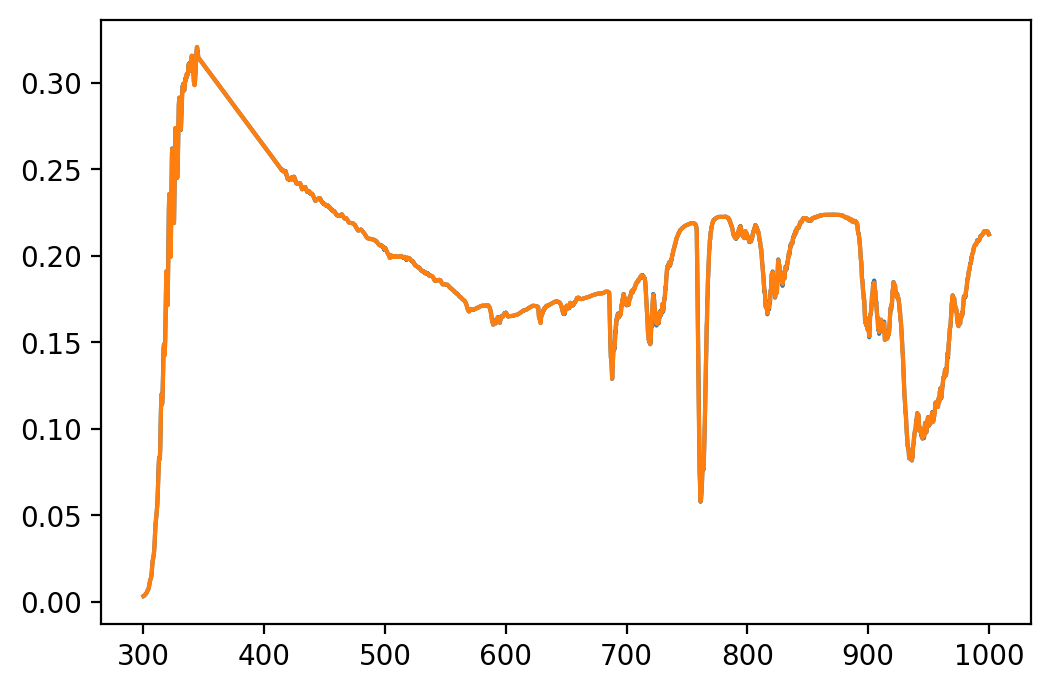

In [37]:
from scipy.ndimage.filters import gaussian_filter
def degrade_spectra_test():
    
    #read synthetic spectrum
    wave_synth =lam_hr[np.logical_and(300<=lam_hr, lam_hr<=1000)]
    flux_synth = albedo_hr[np.logical_and(300<=lam_hr, lam_hr<=1000)]
    
    wave_new = np.exp(np.linspace(np.log(min(wave_synth)), np.log(max(wave_synth)), 4000))
    wave_ref = wave_synth[np.searchsorted(wave_synth, 550)]

    

    #BINNING SPECTRUM
    #
    #the synthetic spectrum needs to be binned to have fewer point in the wavelength dimension (~1700 instead of >100000) 
    dwave = (max(wave_synth) - min(wave_synth)) / len (wave_synth) #"fwhm" of the observed spectrum
    dwave_sigma = dwave / (2 * np.sqrt(2 * np.log(2)))
    
    #before interpolating the spectrum to a new wavelength grid, smooth it with a Gaussian
    flux_conv = gaussian_filter(flux_synth, dwave_sigma)
    print(flux_conv.size)
    flux_conv = np.interp(wave_new, wave_synth, flux_conv)
    
    plt.plot(wave_synth, flux_synth)
    plt.plot(wave_new, flux_conv)
    
    R = 300
    flux_conv = []
    for lam in wave_synth:
        sigma = lam / R / (2 * np.sqrt(2 * np.log(2)))
        lsf = gauss(wave_synth, lam, sigma)
        flux_new = np.sum(flux_synth * lsf)
        flux_conv.append(flux_synth)
        
#     #interpolating the smoothed synthetic spectrum on the observed wavelength grid
#     func_interp = interpolate.splrep(wave_synth, flux_conv) #searching for interpolation function
#     flux_synth_smooth = interpolate.splev(wave_obs, func_interp) #interpolating on a new grid
    
    
#     #DEGRADING SPECTRAL RESOLUTION
#     #
#     R = 2000. #resolution of observed spectra in J band
#     FWHM = wave_synth / R #FWHM of a line profile at a given wavelength
#     G_sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
           
#     #Convolution of the synthetic spectrum with a Gaussian function that has a variable sigma
#     gauss_matr = np.vstack([np.hstack([gauss(x, mu, sig) for x in wave_obs]) for mu, sig in zip(wave_obs, G_sigma)])
#     flux_synth_conv = np.dot(flux_synth_smooth * dwave, gauss_matr) 
degrade_spectra_test()

In [39]:
#read synthetic spectrum
wave_synth =lam_hr[np.logical_and(300<=lam_hr, lam_hr<=1000)]
flux_synth = albedo_hr[np.logical_and(300<=lam_hr, lam_hr<=1000)]

In [67]:
R = 150
flux_conv = []
for lam in wave_synth:
    sigma = lam / R / (2 * np.sqrt(2 * np.log(2)))
    lsf = gauss(wave_synth, lam, sigma)
    lsf /= lsf.sum()
    flux_new = np.sum(flux_synth * lsf)
    flux_conv.append(flux_new)

In [68]:
np.shape(flux_conv)

(23334,)

In [69]:
# Construct new low-res wavelength grid
wl_new, dwl_new = construct_lam(wave_synth.min(), wave_synth.max(), R)

# Down-bin flux to low-res
flux_binned = downbin_spec(flux_conv, wave_synth, wl_new, dlam=dwl_new)


(500.0, 900.0, 0.03, 0.25)

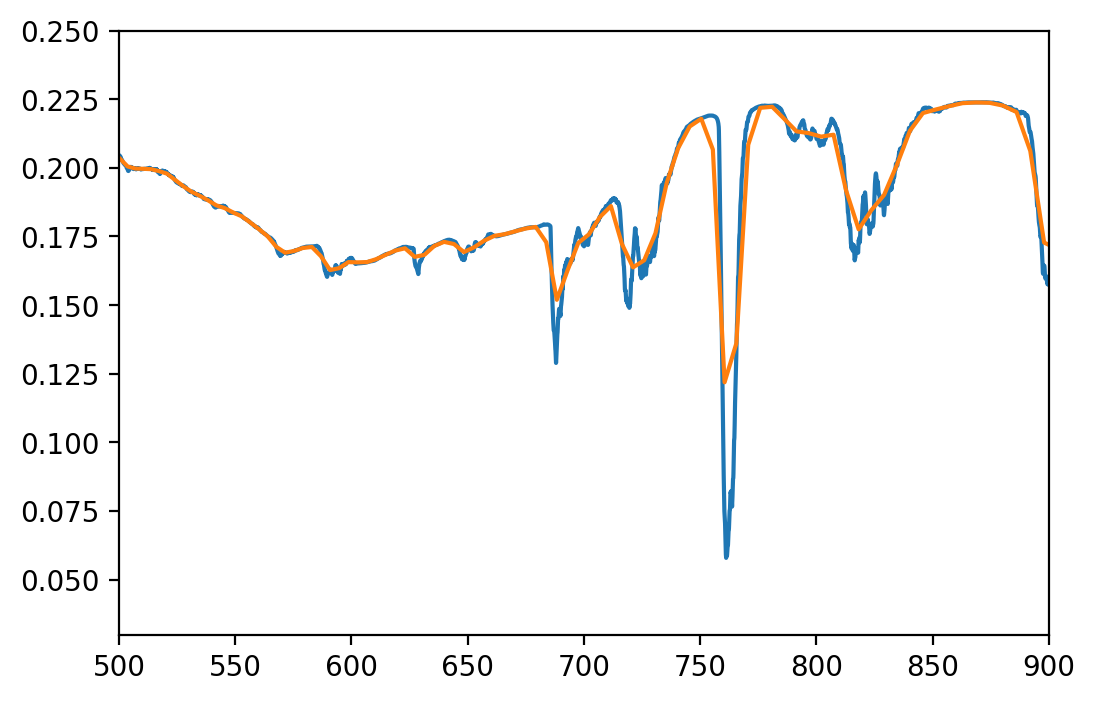

In [71]:
plt.plot(wave_synth, flux_synth)
# plt.plot(wave_synth, flux_conv)
plt.plot(wl_new, flux_binned)
plt.axis([500,900, 0.03, 0.25])

In [38]:
lam_new = lam_hr[np.logical_and(300<=lam_hr, lam_hr<=1000)]

In [22]:
R = 300. #resolution of observed spectra in J band
FWHM = lam_new / R #FWHM of a line profile at a given wavelength
G_sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))

#Convolution of the synthetic spectrum with a Gaussian function that has a variable sigma
gauss_matr = np.vstack([np.hstack([gauss(x, mu, sig) for x in lam_new]) for mu, sig in zip(lam_new, G_sigma)])
flux_synth_conv = np.dot(flux_synth_smooth * dwave, gauss_matr) 

KeyboardInterrupt: 